In [659]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [660]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm 

In [661]:
# from spectres.spectral_resampling import spectres

In [662]:
def make_bins(wavs):
    """ Given a series of wavelength points, find the edges and widths
    of corresponding wavelength bins. """
    edges = np.zeros(wavs.shape[0]+1)
    widths = np.zeros(wavs.shape[0])
    edges[0] = wavs[0] - (wavs[1] - wavs[0])/2
    widths[-1] = (wavs[-1] - wavs[-2])
    edges[-1] = wavs[-1] + (wavs[-1] - wavs[-2])/2
    edges[1:-1] = (wavs[1:] + wavs[:-1])/2
    widths[:-1] = edges[1:-1] - edges[:-2]

    return edges, widths

In [663]:
def spectres(new_wavs, spec_wavs, spec_fluxes, spec_errs=None, fill=None,
             verbose=True):

    """
    Function for resampling spectra (and optionally associated
    uncertainties) onto a new wavelength basis.

    Parameters
    ----------

    new_wavs : numpy.ndarray
        Array containing the new wavelength sampling desired for the
        spectrum or spectra.

    spec_wavs : numpy.ndarray
        1D array containing the current wavelength sampling of the
        spectrum or spectra.

    spec_fluxes : numpy.ndarray
        Array containing spectral fluxes at the wavelengths specified in
        spec_wavs, last dimension must correspond to the shape of
        spec_wavs. Extra dimensions before this may be used to include
        multiple spectra.

    spec_errs : numpy.ndarray (optional)
        Array of the same shape as spec_fluxes containing uncertainties
        associated with each spectral flux value.

    fill : float (optional)
        Where new_wavs extends outside the wavelength range in spec_wavs
        this value will be used as a filler in new_fluxes and new_errs.

    verbose : bool (optional)
        Setting verbose to False will suppress the default warning about
        new_wavs extending outside spec_wavs and "fill" being used.

    Returns
    -------

    new_fluxes : numpy.ndarray
        Array of resampled flux values, first dimension is the same
        length as new_wavs, other dimensions are the same as
        spec_fluxes.

    new_errs : numpy.ndarray
        Array of uncertainties associated with fluxes in new_fluxes.
        Only returned if spec_errs was specified.
    """

    # Rename the input variables for clarity within the function.
    old_wavs = spec_wavs
    old_fluxes = spec_fluxes
    old_errs = spec_errs

    # Make arrays of edge positions and widths for the old and new bins

    old_edges, old_widths = make_bins(old_wavs)
    new_edges, new_widths = make_bins(new_wavs)

    # Generate output arrays to be populated
    new_fluxes = np.zeros(old_fluxes[..., 0].shape + new_wavs.shape)

    if old_errs is not None:
        if old_errs.shape != old_fluxes.shape:
            raise ValueError("If specified, spec_errs must be the same shape "
                             "as spec_fluxes.")
        else:
            new_errs = np.copy(new_fluxes)

    start = 0
    stop = 0

    # Calculate new flux and uncertainty values, looping over new bins
    for j in range(new_wavs.shape[0]):

        # Add filler values if new_wavs extends outside of spec_wavs
        if (new_edges[j] < old_edges[0]) or (new_edges[j+1] > old_edges[-1]):
            new_fluxes[..., j] = fill

            if spec_errs is not None:
                new_errs[..., j] = fill

            # if (j == 0 or j == new_wavs.shape[0]-1) and verbose:
            #     warnings.warn(
            #         "Spectres: new_wavs contains values outside the range "
            #         "in spec_wavs, new_fluxes and new_errs will be filled "
            #         "with the value set in the 'fill' keyword argument "
            #         "(by default 0).",
            #         category=RuntimeWarning,
            #     )
            continue

        # Find first old bin which is partially covered by the new bin
        while old_edges[start+1] <= new_edges[j]:
            start += 1

        # Find last old bin which is partially covered by the new bin
        while old_edges[stop+1] < new_edges[j+1]:
            stop += 1

        # If new bin is fully inside an old bin start and stop are equal
        if stop == start:
            new_fluxes[..., j] = old_fluxes[..., start]
            if old_errs is not None:
                new_errs[..., j] = old_errs[..., start]

        # Otherwise multiply the first and last old bin widths by P_ij
        else:
            start_factor = ((old_edges[start+1] - new_edges[j])
                            / (old_edges[start+1] - old_edges[start]))

            end_factor = ((new_edges[j+1] - old_edges[stop])
                          / (old_edges[stop+1] - old_edges[stop]))

            old_widths[start] *= start_factor
            old_widths[stop] *= end_factor

            # Populate new_fluxes spectrum and uncertainty arrays
            f_widths = old_widths[start:stop+1]*old_fluxes[..., start:stop+1]
            new_fluxes[..., j] = np.sum(f_widths, axis=-1)
            new_fluxes[..., j] /= np.sum(old_widths[start:stop+1])

            if old_errs is not None:
                e_wid = old_widths[start:stop+1]*old_errs[..., start:stop+1]

                new_errs[..., j] = np.sqrt(np.sum(e_wid**2, axis=-1))
                new_errs[..., j] /= np.sum(old_widths[start:stop+1])

            # Put back the old bin widths to their initial values
            old_widths[start] /= start_factor
            old_widths[stop] /= end_factor

    # If errors were supplied return both new_fluxes and new_errs.
    if old_errs is not None:
        return new_fluxes, new_errs

    # Otherwise just return the new_fluxes spectrum array
    else:
        return new_fluxes

In [664]:
# import spectres.spectral_resampling

In [665]:
# from spectres import spectres

In [666]:
def TB_reindex(TB_now):
    TB_now = TB_now.reset_index()
    TB_now = TB_now.drop(columns='index')
    return TB_now

# Global Setting

## Galaxy information

In [667]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

## basic fitting parameters

In [668]:
lam_range_temp = [4800, 5230]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [669]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [670]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

# Data Input

In [671]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 1
        Cut_RHS = 1

        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [672]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

# Devide Voronoi bin

## Parameters pre-set

In [673]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal, norm_range=[4827.875, 5206.375])
# sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal)

In [674]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(Galaxy_info.ln_lam_gal, lam_range_temp, width=1000)
# nbins = np.unique(bin_num).size
# velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
# optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(Galaxy_info.ln_lam_gal)

## SNR calculate

In [675]:
SNR_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])

In [676]:
Galaxy_P2P = pd.read_csv('./../FitData/Fit_DS_20[25Feb05][VCC1588]/'+galaxy_name+'_P2P_SFR.csv')
Galaxy_P2P['Index'] = Galaxy_P2P.index

In [677]:
for Index_num in range(len(Galaxy_P2P)):
        POS_NL = (Galaxy_P2P.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                i = int(k_index/max(Galaxy_info.col))
                j = k_index%max(Galaxy_info.col)

                SNR_map[i,j] = Galaxy_P2P.loc[Index_num,'SNR']

In [678]:
# def Calculater(i,j):
#     K_index = i*max(Galaxy_info.col)+j
#     sp = Galaxy_info.spectra[:,K_index]
#     # x_wave = Galaxy_info.wave
#     sp_cal = sp[ np.where( (lam_gal>5075) & (lam_gal<5125) ) ]
#     # sp_cal = sp[ np.where( (x_wave>5075) & (x_wave<5125) ) ]
    
#     return (np.median(sp)/(np.std(sp)))

In [679]:
# for i in tqdm(range(Galaxy_info.cube.shape[1])):
#     for j in range(Galaxy_info.cube.shape[2]):
#         SNR_map[i,j] = Calculater(i,j)

## Bining

In [680]:
signal = np.median(Galaxy_info.spectra[ np.where((lam_gal>5075) & (lam_gal<5125)) ] , 0)
noise = np.std( Galaxy_info.spectra[ np.where((lam_gal>5075) & (lam_gal<5125)) ], 0)
target_sn = 20

In [681]:
for Index_num in range(len(Galaxy_P2P)):
        POS_NL = (Galaxy_P2P.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                # signal[k_index] = Galaxy_P2P.loc[Index_num,'Signal']
                signal[k_index] = 1
                noise[k_index] = Galaxy_P2P.loc[Index_num,'Noise']
                if noise[k_index] > 3:
                        noise[k_index] = 2

In [682]:
x_ary = []
y_ary = []

In [683]:
for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            x_ary += [Ori_ra + ((Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2)]
            y_ary += [Ori_dec + ((Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2)]

In [684]:
# plt.hist(noise, range=(0,5), bins=20)

In [685]:
VNB = voronoi_2d_binning(np.array(x_ary), np.array(y_ary), signal, noise, target_sn, plot=0)

## Spectrum calculate

In [686]:
def Spectrum_ReSMP(spctrum, lam_gal_wave, st, ed, v_fix):
    Lam_gal_cpy_U = lam_gal_wave.copy()
    for i in range(len(Lam_gal_cpy_U)):
        Lam_gal_cpy_U[i] = Lam_gal_cpy_U[i]/(1+(v_fix/c))
    # lam_gal = np.array(lam_gal_wave)
    W_arg = np.arange(st, ed, (ed-st)/(len(Lam_gal_cpy_U)))
    # W_list = []
    # for i in range(len(lam_gal)):
    #     W_list += [st+i*(ed-st)/(len(lam_gal_wave)-1)]
    return spectres(W_arg, Lam_gal_cpy_U, spctrum)

In [687]:
Lam_gal_cpy = lam_gal.copy()

In [688]:
# lam_gal_wave_test = lam_gal
# for i in range(len(lam_gal_wave_test)):
#         lam_gal_wave_test[i] = lam_gal_wave_test[i]/(1+(10/c))

# W_arg_test = np.arange(4820, 5210, (5210-4820)/(len(lam_gal_wave_test)))

In [689]:
# fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=150, tight_layout=True)
# gs1 = gridspec.GridSpec(1, 1)
# gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
# ax1 = plt.subplot(gs1[0])

# ax1.plot(lam_gal_wave_test, Galaxy_info.spectra[:,0], alpha=.7, label='Old')
# ax1.plot(W_arg_test, Spectrum_ReSMP(Galaxy_info.spectra[:,0], lam_gal, 4820, 5210,10), alpha=.7, label='New')


# ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')

# # ax1.set_ylim(,)
# # ax1.set_xlim(,)

# ax1.set_xlabel(r'', size=11)
# ax1.set_ylabel(r'', size=11)

# ax1.legend()

# # plt.savefig('./', format='pdf', bbox_inches='tight')

In [690]:
Lam_gal_cpy = lam_gal.copy()

VNB_spectrum = np.ndarray(shape=(Galaxy_info.spectra.shape[0], VNB[2].shape[0]))
Spc_vel_fix = np.ndarray(shape=Galaxy_info.spectra.shape)

V_field = np.ndarray(shape=Galaxy_info.spectra.shape[1])

In [691]:


for Index_num in range(len(Galaxy_P2P)):
        POS_NL = (Galaxy_P2P.loc[Index_num,['K_index']])[0].replace('\n', '').replace('[', '').replace(']', '').split()
        for i in range(len(POS_NL)):
                POS_NL[i] = int(POS_NL[i])
        for k_index in POS_NL:
                del_v = Galaxy_P2P.loc[Index_num,'Component_Sol_00']
                # if abs(del_v-V_mid) > del_v_lim:
                #         del_v = V_mid
                # if del_v < -del_v_lim:
                #         del_v = -0
                V_field[k_index] = del_v
                # Spc_vel_fix[:,k_index] += Spectrum_ReSMP(Galaxy_info.spectra[:,k_index], lam_gal_wave = Lam_gal_cpy, st=4827.875, ed=5206.375, v_fix=del_v)

In [692]:
del_v_lim = 300
v_LR = 300

for Index_num in range(len(VNB[2])):
    K_index = np.where(VNB[0] == Index_num)[0]
    V_mid = np.median(V_field[K_index])
    for i in K_index:
        if abs(V_field[i]-V_mid)>del_v_lim:
            V_field[i] = V_mid
        if abs(V_field[i]) > v_LR:
            V_field[i] = 0
        Spc_vel_fix[:,i] += Spectrum_ReSMP(Galaxy_info.spectra[:,i], lam_gal_wave = Lam_gal_cpy, st=4827.875, ed=5206.375, v_fix=del_v)
    VNB_spectrum[:,Index_num] = np.median(Spc_vel_fix[:,K_index],1)

# Fitting

## FTF (First time fitting)

In [693]:
lam_use = np.arange(4827.875, 5206.375, (5206.375-4827.875)/(len(lam_gal)))
velscale = np.min(c*np.diff(np.log(lam_use)))

VNB_spectrum_new, ln_lam_gal_new, velscale_new = util.log_rebin([4827.875, 5206.375], VNB_spectrum, velscale=velscale)

In [694]:
sps = lib.sps_lib(filename, velscale_new, FWHM_gal, norm_range=[4827.875, 5206.375])

npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

In [695]:
lam_gal_new = np.exp(ln_lam_gal_new)
lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0_new = util.determine_mask(ln_lam_gal_new, lam_range_temp, width=500)

In [696]:
mask0_new

array([ True,  True,  True, ...,  True,  True,  True])

In [697]:
velscale_ratio = 1
# velscale = Galaxy_info.velscale

velfield_VNB = np.ndarray(shape=VNB[2].shape[0])
sigfield_VNB = np.ndarray(shape=VNB[2].shape[0])
tempnum_VNB = np.ndarray(shape=VNB[2].shape[0])
Bestfitfield_VNB = np.ndarray(shape=VNB_spectrum_new.shape)

optimal_templates_VNB = np.ndarray(shape=(npix,VNB[2].shape[0]))

apoly=[]

In [698]:
for i in tqdm(range(len(VNB[2]))):
    plot_TF = True if (i == 1000) else False
    tmpgalaxy = VNB_spectrum_new[:,i]
    noise = np.full_like(tmpgalaxy,0.1)
    noise = np.ones_like(tmpgalaxy)

    pp = ppxf(sps.templates, tmpgalaxy, noise, velscale_new, [vel_s, vel_dis_s],
                            plot=plot_TF,
                            mask=mask0_new,
                            velscale_ratio = 1,
                            lam=lam_gal_new, lam_temp=sps.lam_temp,
                            quiet=not plot_TF)
                    # pp_field[i][j]=pp
    Bestfitfield_VNB[:,i]=pp.bestfit

    pp.optimal_template = sps.templates.reshape(sps.templates.shape[0], -1) @ pp.weights
    optimal_templates_VNB[:,i] = pp.optimal_template
    velfield_VNB[i] = pp.sol[0]
    sigfield_VNB[i] = pp.sol[1]
    weights = pp.weights
    indwt = np.where(weights == np.max(weights))[0]
    tempnum_VNB[i] = indwt[0]

    apoly += [pp.apoly]

100%|██████████| 28/28 [00:13<00:00,  2.06it/s]


## Addtional parameters setting

In [699]:
Index_Wave = pd.DataFrame({
        'Index':['H_beta','Fe_5015','Mg_b','Fe_5270','Fe_5270_s'],
        'BPC_range':[[4827.875,4847.875],[4946.500,4977.750],[5142.625,5161.375],[5233.150,5248.150],[5233.000,5250.000]],
        'CBP_range':[[4847.875,4876.625],[4977.750,5054.000],[5160.125,5192.625],[5245.650,5285.650],[5256.500,5278.500]],
        'RPC_range':[[4876.625,4891.625],[5054.000,5065.250],[5191.375,5206.375],[5285.650,5318.150],[5285.500,5308.000]]
})

In [700]:
Index_use = [0,1,2]

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_30820\267478818.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


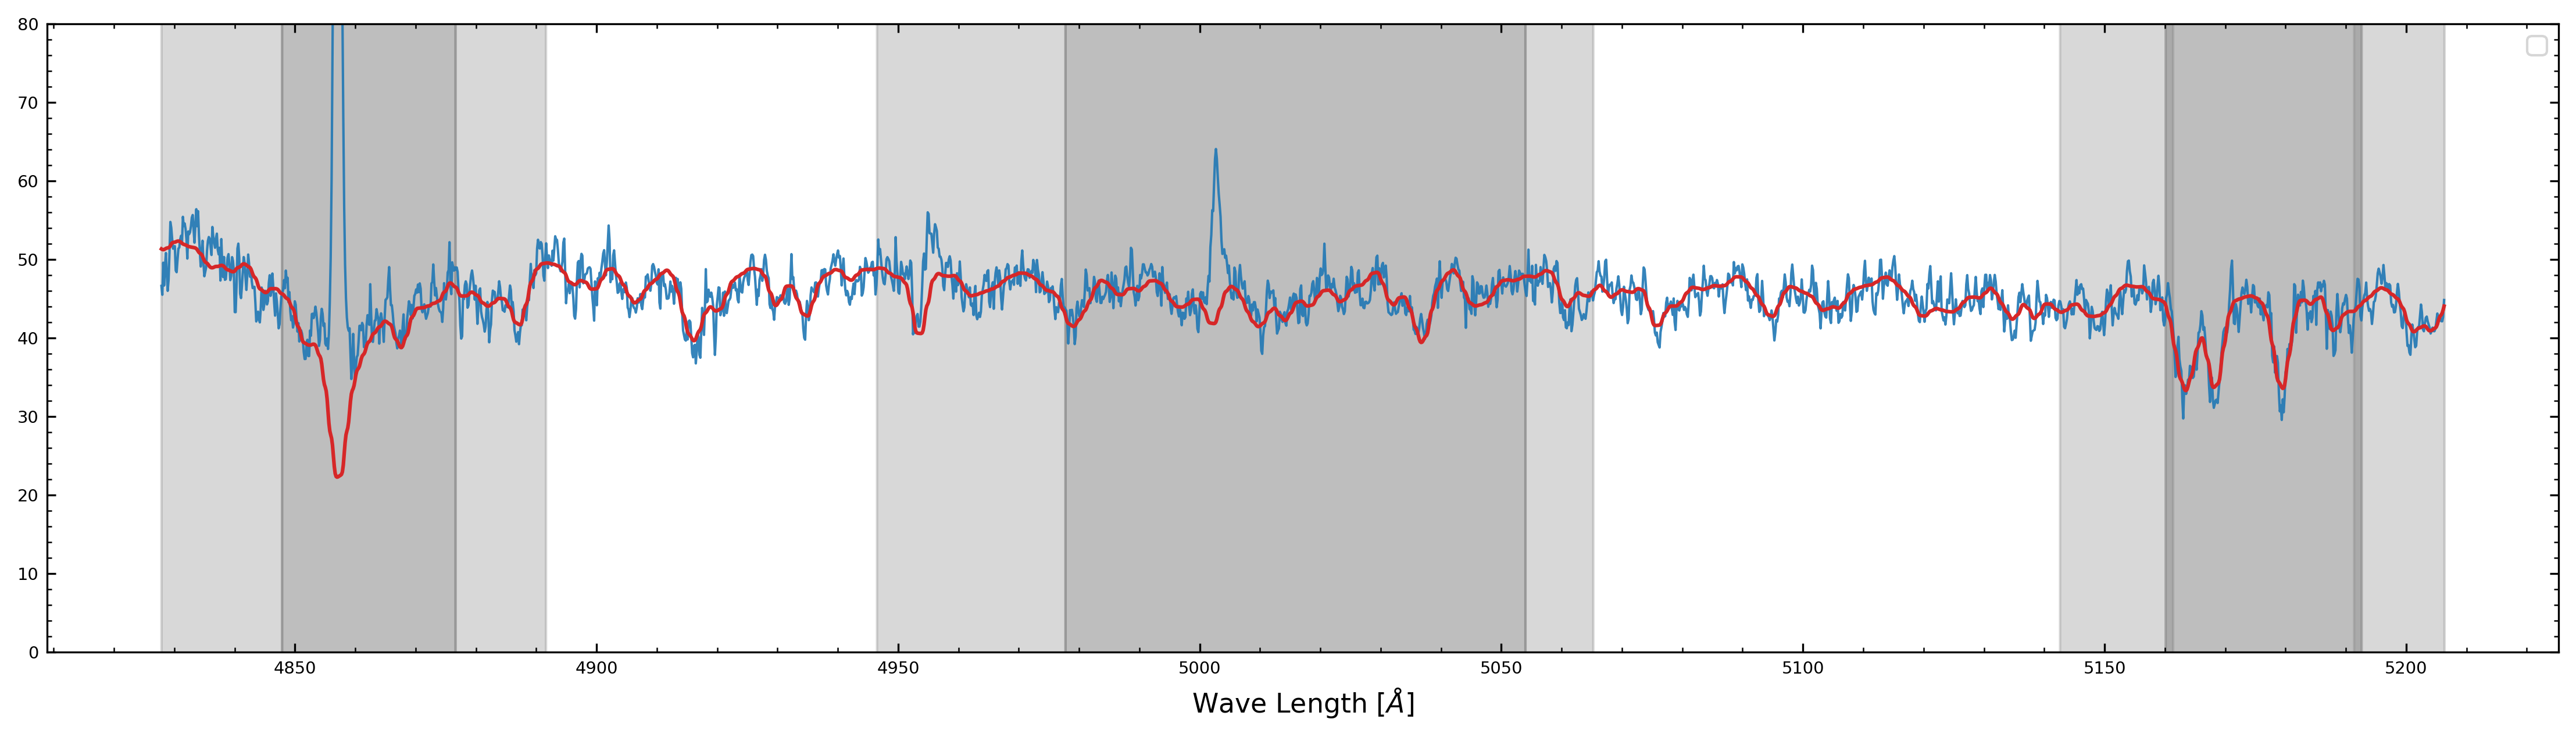

In [701]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal_new,VNB_spectrum_new[:,2], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal_new,Bestfitfield_VNB[:,2], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(0,80)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## STF

In [702]:
lam_gal = lam_gal_new

### STF parameters setting

In [703]:
lam_range_gal = [np.min(lam_gal_new), np.max(lam_gal_new)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, Galaxy_info.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


In [704]:
ngas_comp = 1   # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

### Fitting

In [705]:
PP_box = []
for i in tqdm(range(len(VNB[2]))):
        galaxy = VNB_spectrum_new[:,i]
        noise = np.ones_like(galaxy)

        template = optimal_templates_VNB[:,i]
        stars_gas_templates = np.column_stack([template, gas_templates])

        component = [0] + [1]*2
        gas_component=np.array(component) > 0
        moments = [-2, 2]
        ncomp = len(moments)
        tied = [['', ''] for _ in range(ncomp)]

        start = [[velfield_VNB[i], sigfield_VNB[i]],
        [velfield_VNB[i], 50]]
        # start = [[0, 50],
        # [0, 200]]

        vlim = lambda x: velfield_VNB[i] + x*np.array([-100, 100])
        bounds = [[vlim(2), [20, 300]],
                  [vlim(2), [20, 100]]]

        pp = ppxf(stars_gas_templates, galaxy, noise, velscale, start,
            plot=False,
            moments=moments, degree=8, mdegree=-1,
            component=component, 
            gas_component=gas_component, gas_names=gas_names,
            lam=lam_gal_new, lam_temp=sps.lam_temp, tied=tied,
            bounds=bounds,
            global_search=True)
        
        PP_box += [pp]

  0%|          | 0/28 [00:00<?, ?it/s]

differential_evolution step 1: f(x)= 2792.16
differential_evolution step 2: f(x)= 2075.1
differential_evolution step 3: f(x)= 1718.07
differential_evolution step 4: f(x)= 1718.07
differential_evolution step 5: f(x)= 1717.07
differential_evolution step 6: f(x)= 1716.28
differential_evolution step 7: f(x)= 1693.84
differential_evolution step 8: f(x)= 1681.55


  4%|▎         | 1/28 [00:00<00:18,  1.46it/s]

differential_evolution step 9: f(x)= 1681.55
 Best Fit:       Vel     sigma
 comp.  0:      -248        20
 comp.  1:      -248        20
chi2/DOF: 0.6832; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 300
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.917       306      55.6
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      305.9       3.6    -248    20
Comp:  1      [OIII]5007_d_(1)      73.96       4.5    -248    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 13652.8
differential_evolution step 2: f(x)= 12529.3
differential_evolution step 3: f(x)= 12481.6
differential_evolution step 4: f(x)= 12455.5
differential_evolution

  7%|▋         | 2/28 [00:01<00:14,  1.77it/s]

differential_evolution step 6: f(x)= 12454.6
 Best Fit:       Vel     sigma
 comp.  0:      -232        20
 comp.  1:      -206        21
chi2/DOF: 5.061; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.901       452       167
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      451.6       3.6    -206    21
Comp:  1      [OIII]5007_d_(1)      222.2       4.5    -206    21
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 24541.8
differential_evolution step 2: f(x)= 11637.1
differential_evolution step 3: f(x)= 11637.1
differential_evolution step 4: f(x)= 11637.1
differential_evolution 

 11%|█         | 3/28 [00:02<00:18,  1.36it/s]

differential_evolution step 10: f(x)= 10925.4
differential_evolution step 11: f(x)= 10925.4
differential_evolution step 12: f(x)= 10908.4
differential_evolution step 13: f(x)= 10908.4
 Best Fit:       Vel     sigma
 comp.  0:      -245        20
 comp.  1:      -262        20
chi2/DOF: 4.411; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 420
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.914   1.6e+03       193
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      1596.       3.6    -262    20
Comp:  1      [OIII]5007_d_(1)      256.3       4.5    -262    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 8624.83
differential_evolut

 14%|█▍        | 4/28 [00:02<00:14,  1.63it/s]

differential_evolution step 5: f(x)= 7144
 Best Fit:       Vel     sigma
 comp.  0:      -228        20
 comp.  1:      -220        23
chi2/DOF: 2.885; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 180
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.959       380       103
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      380.1       3.7    -220    23
Comp:  1      [OIII]5007_d_(1)      136.7       4.6    -220    23
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 14857.9


 18%|█▊        | 5/28 [00:02<00:12,  1.86it/s]

differential_evolution step 2: f(x)= 12530.7
differential_evolution step 3: f(x)= 12530.7
differential_evolution step 4: f(x)= 12513.4
differential_evolution step 5: f(x)= 12513.4
 Best Fit:       Vel     sigma
 comp.  0:      -246        20
 comp.  1:      -266        24
chi2/DOF: 5.078; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 180
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.946       692       137
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      692.4       3.7    -266    24
Comp:  1      [OIII]5007_d_(1)      182.0       4.7    -266    24
-----------------------------------------------------------------


 21%|██▏       | 6/28 [00:03<00:10,  2.20it/s]

differential_evolution step 1: f(x)= 6220.03
differential_evolution step 2: f(x)= 6098.27
differential_evolution step 3: f(x)= 6098.27
 Best Fit:       Vel     sigma
 comp.  0:      -258        20
 comp.  1:      -264        24
chi2/DOF: 2.477; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 120
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.936       288      63.2
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      287.7       3.7    -264    24
Comp:  1      [OIII]5007_d_(1)      84.07       4.6    -264    24
-----------------------------------------------------------------


 25%|██▌       | 7/28 [00:03<00:08,  2.40it/s]

differential_evolution step 1: f(x)= 7691.85
differential_evolution step 2: f(x)= 6717.76
differential_evolution step 3: f(x)= 6509.41
differential_evolution step 4: f(x)= 6509.41
 Best Fit:       Vel     sigma
 comp.  0:      -234        20
 comp.  1:      -233        20
chi2/DOF: 2.635; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.965       324        81
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      323.8       3.6    -233    20
Comp:  1      [OIII]5007_d_(1)      107.8       4.5    -233    20
-----------------------------------------------------------------


 29%|██▊       | 8/28 [00:03<00:08,  2.50it/s]

differential_evolution step 1: f(x)= 9810.2
differential_evolution step 2: f(x)= 9296.56
differential_evolution step 3: f(x)= 9007.48
differential_evolution step 4: f(x)= 8994.26
 Best Fit:       Vel     sigma
 comp.  0:      -252        20
 comp.  1:      -268        26
chi2/DOF: 3.636; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.966       580       107
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      579.5       3.8    -268    26
Comp:  1      [OIII]5007_d_(1)      142.5       4.7    -268    26
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 53035.6
differential_evolution 

 32%|███▏      | 9/28 [00:04<00:08,  2.37it/s]

differential_evolution step 5: f(x)= 42058.9
differential_evolution step 6: f(x)= 42058.9
 Best Fit:       Vel     sigma
 comp.  0:      -247        20
 comp.  1:      -275        29
chi2/DOF: 17.08; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.955  1.73e+03       473
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      1735.       3.9    -275    29
Comp:  1      [OIII]5007_d_(1)      628.6       4.9    -275    29
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 6513.81


 36%|███▌      | 10/28 [00:04<00:06,  2.96it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -237        20
 comp.  1:      -230        34
chi2/DOF: 2.597; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.956       193      71.7
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      193.2       4.1    -230    34
Comp:  1      [OIII]5007_d_(1)      95.39       5.1    -230    34
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 18015.1
differential_evolution step 2: f(x)= 17484.8


 39%|███▉      | 11/28 [00:04<00:05,  2.99it/s]

differential_evolution step 3: f(x)= 17330.4
differential_evolution step 4: f(x)= 17247.5
 Best Fit:       Vel     sigma
 comp.  0:      -248        20
 comp.  1:      -263        32
chi2/DOF: 6.971; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.981       892       201
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      891.8       4.0    -263    32
Comp:  1      [OIII]5007_d_(1)      267.8       5.0    -263    32
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 26077.2


 43%|████▎     | 12/28 [00:05<00:05,  3.18it/s]

differential_evolution step 2: f(x)= 25948.5
differential_evolution step 3: f(x)= 25948.5
 Best Fit:       Vel     sigma
 comp.  0:      -260        20
 comp.  1:      -276        35
chi2/DOF: 10.53; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 120
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.941       581       174
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      580.8       4.1    -276    35
Comp:  1      [OIII]5007_d_(1)      231.8       5.2    -276    35
-----------------------------------------------------------------


 46%|████▋     | 13/28 [00:05<00:04,  3.10it/s]

differential_evolution step 1: f(x)= 860.803
differential_evolution step 2: f(x)= 782.296
differential_evolution step 3: f(x)= 770.921
differential_evolution step 4: f(x)= 770.921
 Best Fit:       Vel     sigma
 comp.  0:      -268        20
 comp.  1:      -278        28
chi2/DOF: 0.3134; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.933       137      26.7
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      137.2       3.9    -278    28
Comp:  1      [OIII]5007_d_(1)      35.55       4.8    -278    28
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 12507.8
differential_evolution

 50%|█████     | 14/28 [00:05<00:05,  2.64it/s]

differential_evolution step 5: f(x)= 8190.67
differential_evolution step 6: f(x)= 8111.93
 Best Fit:       Vel     sigma
 comp.  0:      -244        20
 comp.  1:      -244        23
chi2/DOF: 3.281; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.945       680       127
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      680.0       3.7    -244    23
Comp:  1      [OIII]5007_d_(1)      168.7       4.6    -244    23
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 13185.4
differential_evolution step 2: f(x)= 11350.2
differential_evolution step 3: f(x)= 11350.2
differential_evolution 

 54%|█████▎    | 15/28 [00:06<00:05,  2.45it/s]

differential_evolution step 5: f(x)= 11350.2
differential_evolution step 6: f(x)= 11308.2
 Best Fit:       Vel     sigma
 comp.  0:      -261        20
 comp.  1:      -279        20
chi2/DOF: 4.583; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.953       569       115
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      568.5       3.6    -279    20
Comp:  1      [OIII]5007_d_(1)      153.1       4.5    -279    20
-----------------------------------------------------------------


 57%|█████▋    | 16/28 [00:06<00:04,  2.59it/s]

differential_evolution step 1: f(x)= 4161.56
differential_evolution step 2: f(x)= 3917.03
differential_evolution step 3: f(x)= 3917.03
differential_evolution step 4: f(x)= 3917.03
 Best Fit:       Vel     sigma
 comp.  0:      -268        20
 comp.  1:      -284        25
chi2/DOF: 1.588; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      0.94       230      53.1
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      230.2       3.7    -284    25
Comp:  1      [OIII]5007_d_(1)      70.58       4.7    -284    25
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 15984.2
differential_evolution

 61%|██████    | 17/28 [00:07<00:05,  2.03it/s]

differential_evolution step 9: f(x)= 9888.18
differential_evolution step 10: f(x)= 9871.33
 Best Fit:       Vel     sigma
 comp.  0:      -262        20
 comp.  1:      -274        20
chi2/DOF: 4.008; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 330
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
         1       825       138
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      825.5       3.6    -274    20
Comp:  1      [OIII]5007_d_(1)      183.5       4.5    -274    20
-----------------------------------------------------------------


 68%|██████▊   | 19/28 [00:07<00:03,  3.00it/s]

differential_evolution step 1: f(x)= 2565.58
 Best Fit:       Vel     sigma
 comp.  0:      -267        20
 comp.  1:      -293        20
chi2/DOF: 1.011; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.04        92      18.3
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      92.03       3.6    -293    20
Comp:  1      [OIII]5007_d_(1)      24.28       4.5    -293    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 12601.4
 Best Fit:       Vel     sigma
 comp.  0:      -282        20
 comp.  1:      -304        23
chi2/DOF: 5.096; DOF: 2460; degree = 8; mdegree = 0
Global search

 71%|███████▏  | 20/28 [00:08<00:02,  3.51it/s]

differential_evolution step 1: f(x)= 23572.7
 Best Fit:       Vel     sigma
 comp.  0:      -288        20
 comp.  1:      -324        72
chi2/DOF: 9.581; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      1.01       171      19.6
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      170.6       5.5    -324    72
Comp:  1      [OIII]5007_d_(1)      26.03       6.9    -324    72
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1711.57
differential_evolution step 2: f(x)= 1494.87
differential_evolution step 3: f(x)= 1493.77
differential_evolution step 4: f(x)= 1492.71
differential_evolution s

 75%|███████▌  | 21/28 [00:08<00:02,  2.87it/s]

differential_evolution step 6: f(x)= 1481.1
 Best Fit:       Vel     sigma
 comp.  0:      -282        20
 comp.  1:      -306        20
chi2/DOF: 0.5993; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 210
method = capfit; Jac calls: 2; Func calls: 8; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
      0.99       181        38
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      180.7       3.6    -306    20
Comp:  1      [OIII]5007_d_(1)      50.59       4.5    -306    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4286.19


 79%|███████▊  | 22/28 [00:08<00:02,  2.87it/s]

differential_evolution step 2: f(x)= 4026.76
differential_evolution step 3: f(x)= 4026.76
differential_evolution step 4: f(x)= 4026.76
 Best Fit:       Vel     sigma
 comp.  0:      -251        20
 comp.  1:      -260        20
chi2/DOF: 1.598; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.939       308      74.3
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      308.4       3.6    -260    20
Comp:  1      [OIII]5007_d_(1)      98.85       4.5    -260    20
-----------------------------------------------------------------


 82%|████████▏ | 23/28 [00:09<00:01,  3.25it/s]

differential_evolution step 1: f(x)= 8564.23
 Best Fit:       Vel     sigma
 comp.  0:      -227        20
 comp.  1:      -235        20
chi2/DOF: 3.207; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.925       244      49.9
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      244.4       3.6    -235    20
Comp:  1      [OIII]5007_d_(1)      66.37       4.5    -235    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 6026.56


 86%|████████▌ | 24/28 [00:09<00:01,  3.29it/s]

differential_evolution step 2: f(x)= 5979.46
differential_evolution step 3: f(x)= 5979.46
 Best Fit:       Vel     sigma
 comp.  0:      -244        20
 comp.  1:      -239        39
chi2/DOF: 2.423; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 120
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.885       264      74.8
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      263.8       4.3    -239    39
Comp:  1      [OIII]5007_d_(1)      99.52       5.4    -239    39
-----------------------------------------------------------------


 89%|████████▉ | 25/28 [00:09<00:00,  3.26it/s]

differential_evolution step 1: f(x)= 1797.64
differential_evolution step 2: f(x)= 1752.94
differential_evolution step 3: f(x)= 1752.71
 Best Fit:       Vel     sigma
 comp.  0:      -208        21
 comp.  1:      -204        35
chi2/DOF: 0.7122; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 120
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.972       134      30.1
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      134.0       4.1    -204    35
Comp:  1      [OIII]5007_d_(1)      40.08       5.2    -204    35
-----------------------------------------------------------------


 93%|█████████▎| 26/28 [00:09<00:00,  3.77it/s]

differential_evolution step 1: f(x)= 6990.34
 Best Fit:       Vel     sigma
 comp.  0:      -257        20
 comp.  1:      -272        98
chi2/DOF: 2.841; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
     0.662       114         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      114.5       6.3    -272    98
Comp:  1      [OIII]5007_d_(1)      0.000       7.9    -272    98
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1757.13


 96%|█████████▋| 27/28 [00:10<00:00,  4.01it/s]

 Best Fit:       Vel     sigma
 comp.  0:      -215        20
 comp.  1:      -202        32
chi2/DOF: 0.7118; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.663        45      9.33
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      45.05       4.0    -202    32
Comp:  1      [OIII]5007_d_(1)      12.41       5.0    -202    32
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1241.1


100%|██████████| 28/28 [00:10<00:00,  2.67it/s]

differential_evolution step 2: f(x)= 1180.99
differential_evolution step 3: f(x)= 1180.99
differential_evolution step 4: f(x)= 1180.99
 Best Fit:       Vel     sigma
 comp.  0:      -221        20
 comp.  1:      -209        37
chi2/DOF: 0.4797; DOF: 2460; degree = 8; mdegree = 0
Global search - Func calls: 150
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/3
Templates weights:
     0.894       156      52.7
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      155.9       4.2    -209    37
Comp:  1      [OIII]5007_d_(1)      70.15       5.3    -209    37
-----------------------------------------------------------------


In [706]:
def CK_SpFT(I_index):
    K_index = I_index

    lam_gal = lam_gal_new.copy()
    for i in range(len(lam_gal)):
        lam_gal[i] = lam_gal[i]/(1+(PP_box[K_index].sol[0][0]/c))

    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,12), dpi=300, tight_layout=True)
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=.95, bottom=0.65, top=0.95, hspace=0.0)
    ax1 = plt.subplot(gs1[0])

    gs2 = gridspec.GridSpec(1, 1)
    gs2.update(left=0.05, right=.95, bottom=0.35, top=0.65, hspace=0.0)
    ax2 = plt.subplot(gs2[0])

    gs3 = gridspec.GridSpec(1, 1)
    gs3.update(left=0.05, right=.95, bottom=0.05, top=0.35, hspace=0.0)
    ax3 = plt.subplot(gs3[0])


# -------------------------------------------------------------------------------------------------------------------------------------

    ax1.plot(lam_gal,VNB_spectrum_new[:,I_index], c='tab:blue', lw=1, alpha=.9, label=galaxy_name+'\npixel:[{:}]'.format(I_index))
    ax1.plot(lam_gal,Bestfitfield_VNB[:,I_index], '--', c='tab:red', alpha=.9)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'CBP_range'][0]
        RHS = Index_Wave.loc[i,'CBP_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'BPC_range'][0]
        RHS = Index_Wave.loc[i,'BPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
    for i in Index_use:
        LHS = Index_Wave.loc[i,'RPC_range'][0]
        RHS = Index_Wave.loc[i,'RPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

    for i in [0]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

    for i in [1]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)

    ax1.plot(lam_gal,PP_box[K_index].bestfit, '-', lw=.7, c='tab:red')


# -------------------------------------------------------------------------------------------------------------------------------------

    ax2.plot(lam_gal, np.zeros(lam_gal.shape), '-', color='k', lw=.7, alpha=.9, zorder = 0)
    ax2.plot(lam_gal, [np.median(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)]*lam_gal.shape[0], '--', color='tab:blue', lw=1, alpha=.9, zorder = 1)
    MPSig = np.median(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit) + np.std(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)
    MMSig = np.median(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit) - np.std(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)
    ax2.fill([min(lam_gal), max(lam_gal), max(lam_gal), min(lam_gal)], [MPSig, MPSig, MMSig, MMSig], color='tab:gray', alpha=.2,
             label=r'Range:{:1.3f}$\pm${:1.3f}'.format(np.median(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit), np.std(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)), zorder=1)
    ax2.plot(lam_gal, VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit, '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)

# -------------------------------------------------------------------------------------------------------------------------------------

    ax3.plot(lam_gal, VNB_spectrum_new[:,I_index]-Bestfitfield_VNB[:,I_index], '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)
    for i in [0]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 2, alpha=.9)
    for i in [1]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 2, alpha=.9)
    
    ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,0]+PP_box[K_index].gas_bestfit_templates[:,1, ], lw=.7, color='tab:red', zorder = 2, alpha=.9)


# -------------------------------------------------------------------------------------------------------------------------------------


    ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    

    # ax1.set_xlim(min(lam_gal), max(lam_gal))
    # ax2.set_xlim(min(lam_gal), max(lam_gal))
    # ax3.set_xlim(min(lam_gal), max(lam_gal))
    ax1.set_xlim(4822, 5212)
    ax2.set_xlim(4822, 5212)
    ax3.set_xlim(4822, 5212)
    ax1.set_ylim(0,max(VNB_spectrum_new[:,I_index])*1.1)
    ax2.set_ylim(min(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)*1.2, max(VNB_spectrum_new[:,I_index]-PP_box[K_index].bestfit)*1.2)
    ax3.set_ylim(min(VNB_spectrum_new[:,I_index]-Bestfitfield_VNB[:,I_index])*1.2, max(VNB_spectrum_new[:,I_index]-Bestfitfield_VNB[:,I_index])*1.2)

    ax3.set_xlabel(r'Wave Length $[\AA]$', size=11)
    
    ax1.legend()
    ax2.legend()
    # ax3.legend()
    plt.show()
    plt.savefig('E:/ProGram/Dr.Zheng/2024NAOC-IUS/Wkp/FitPlot/Fit_08[25Feb09][VCC1588RDBFit]/VNB_res/'+galaxy_name+'VNBFig[{:}].pdf'.format(K_index), format='pdf', bbox_inches='tight')
    plt.clf()
    plt.close()

    PP_box[K_index] = []

In [707]:
# for i in range(len(VNB[6])):
#     CK_SpFT(i)

# Data collect

## Spectrum Index

In [708]:
class LineIndexCalculator:
    def __init__(self, wave, flux, fit_wave, fit_flux, em_wave=None, em_flux_list=None, velocity_correction=0, error=None):
        """
        初始化吸收线指数计算器
        
        Parameters:
        -----------
        wave : array-like
            原始光谱的波长数组
        flux : array-like
            原始光谱的流量数组
        fit_wave : array-like
            拟合光谱的波长数组，用于计算连续谱
        fit_flux : array-like
            拟合光谱的流量数组，用于计算连续谱
        em_wave : array-like, optional
            发射线的波长数组
        em_flux_list : array-like, optional
            合并后的发射线光谱
        velocity_correction : float, optional
            速度修正值，单位为km/s，默认为0
        error : array-like, optional
            误差数组
        """
        self.c = 299792.458  # 光速，单位为km/s
        self.velocity = velocity_correction
        
        # 进行速度修正
        self.wave = self._apply_velocity_correction(wave)
        self.flux = flux.copy()  # 创建副本以避免修改原始数据

        # self.fit_wave = self._apply_velocity_correction(fit_wave)
        self.fit_wave = fit_wave

        self.fit_flux = fit_flux
        self.error = error if error is not None else np.ones_like(flux)
        
        # 处理发射线
        if em_wave is not None and em_flux_list is not None:
            self.em_wave = self._apply_velocity_correction(em_wave)
            self.em_flux_list = em_flux_list
            self._subtract_emission_lines()
    
    def _subtract_emission_lines(self):
        """
        从原始光谱中减去发射线
        输入的em_flux_list已经是合并后的结果
        """
        # 将发射线光谱重采样到原始光谱的波长网格上
        em_flux_resampled = spectres(self.wave, self.em_wave, self.em_flux_list)
        
        # 从原始光谱中减去发射线
        self.flux -= em_flux_resampled
    
    def _apply_velocity_correction(self, wave):
        """
        应用速度修正到波长
        
        Parameters:
        -----------
        wave : array-like
            原始波长数组
            
        Returns:
        --------
        array-like : 修正后的波长数组
        """
        return wave / (1 + (self.velocity/self.c))
        
    def define_line_windows(self, line_name):
        """
        定义吸收线和连续谱窗口
        
        Parameters:
        -----------
        line_name : str
            吸收线名称
            
        Returns:
        --------
        dict : 包含蓝端、中心和红端窗口的字典
        """
        windows = {
            'Hbeta': {
                'blue': (4827.875, 4847.875),
                'line': (4847.875, 4876.625),
                'red': (4876.625, 4891.625)
            },
            'Mgb': {
                'blue': (5142.625, 5161.375),
                'line': (5160.125, 5192.625),
                'red': (5191.375, 5206.375)
            },
            'Fe5015': {
                'blue': (4946.500, 4977.750),
                'line': (4977.750, 5054.000),
                'red': (5054.000, 5065.250)
            }
        }
        return windows.get(line_name)

    def calculate_pseudo_continuum(self, wave_range, flux_range):
        """
        计算伪连续谱
        
        Parameters:
        -----------
        wave_range : array-like
            波长范围
        flux_range : array-like
            对应的流量值
            
        Returns:
        --------
        float : 伪连续谱值
        """
        return np.median(flux_range)

    def calculate_index(self, line_name, return_error=False):
        """
        计算吸收线指数
        
        Parameters:
        -----------
        line_name : str
            吸收线名称 ('Hbeta', 'Mgb', 或 'Fe5015')
        return_error : bool
            是否返回误差
            
        Returns:
        --------
        float : 吸收线指数值
        float : 误差值（如果return_error=True）
        """
        # 获取窗口定义
        windows = self.define_line_windows(line_name)
        if windows is None:
            raise ValueError(f"未知的吸收线: {line_name}")

        # 提取各个区域的数据
        def get_fit_region(region):
            mask = (self.fit_wave >= windows[region][0]) & (self.fit_wave <= windows[region][1])
            return self.fit_wave[mask], self.fit_flux[mask]

        def get_orig_region(region):
            mask = (self.wave >= windows[region][0]) & (self.wave <= windows[region][1])
            return self.wave[mask], self.flux[mask], self.error[mask]

        # 获取数据
        blue_wave_fit, blue_flux_fit = get_fit_region('blue')
        red_wave_fit, red_flux_fit = get_fit_region('red')
        line_wave, line_flux, line_err = get_orig_region('line')

        # 检查数据点数
        if len(blue_flux_fit) < 3 or len(line_flux) < 3 or len(red_flux_fit) < 3:
            return np.nan if not return_error else (np.nan, np.nan)

        # 计算连续谱
        blue_cont = self.calculate_pseudo_continuum(blue_wave_fit, blue_flux_fit)
        red_cont = self.calculate_pseudo_continuum(red_wave_fit, red_flux_fit)
        
        wave_cont = np.array([np.mean(blue_wave_fit), np.mean(red_wave_fit)])
        flux_cont = np.array([blue_cont, red_cont])
        
        # 线性插值得到连续谱
        f_interp = interpolate.interp1d(wave_cont, flux_cont)
        cont_at_line = f_interp(line_wave)

        # 计算积分
        delta_lambda = np.mean(np.diff(line_wave))  # 波长间隔
        index = np.trapz((1.0 - line_flux/cont_at_line), line_wave)  # 使用梯形法则进行积分
        
        if return_error:
            # 计算误差
            error = np.sqrt(np.trapz((line_err/cont_at_line)**2, line_wave))
            return index, error
        
        return index

    def plot_line_fit(self, line_name):
        """
        绘制吸收线拟合结果，包含原始输入数据的对比
        
        Parameters:
        -----------
        line_name : str
            吸收线名称
        """
        windows = self.define_line_windows(line_name)
        
        # 设置x轴范围：窗口范围左右各扩展20埃
        x_min = windows['blue'][0] - 20
        x_max = windows['red'][1] + 20
        
        # 创建两个子图
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[1, 1])
        
        # 计算y轴范围
        # 确保使用相同波长网格的数据
        wave_mask = (self.wave >= x_min) & (self.wave <= x_max)
        em_mask = (self.em_wave >= x_min) & (self.em_wave <= x_max)
        fit_mask = (self.fit_wave >= x_min) & (self.fit_wave <= x_max)
        
        # 计算这个范围内的最大最小值
        flux_range = self.flux[wave_mask] + self.em_flux_list[wave_mask]
        fit_range = self.fit_flux[fit_mask]
        
        y_min = min(np.min(flux_range), np.min(fit_range)) * 0.9
        y_max = max(np.max(flux_range), np.max(fit_range)) * 1.1
        
        # 第一个面板：原始输入数据
        ax1.plot(self.wave, self.flux + self.em_flux_list, 'k-', label='Original Spectrum', alpha=0.7)
        ax1.plot(self.em_wave, self.em_flux_list, 'r-', label='Emission Lines', alpha=0.7)
        ax1.plot(self.fit_wave, self.fit_flux, 'b-', label='Template Fit', alpha=0.7)
        
        # 标记各个区域
        colors = {'blue': 'b', 'line': 'g', 'red': 'r'}
        for region, (start, end) in windows.items():
            ax1.axvspan(start, end, alpha=0.2, color=colors[region])

        ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
        
        ax1.set_xlim(x_min, x_max)
        ax1.set_ylim(y_min, y_max)  # 设置y轴范围
        ax1.set_xlabel('Rest-frame Wavelength (Å)')
        ax1.set_ylabel('Flux')
        ax1.set_title(f'Original Data Comparison (v={self.velocity:.1f} km/s)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 为第二个面板计算y轴范围
        processed_flux = self.flux[wave_mask]
        fit_flux_range = self.fit_flux[fit_mask]
        y_min_processed = min(np.min(processed_flux), np.min(fit_flux_range)) * 0.9
        y_max_processed = max(np.max(processed_flux), np.max(fit_flux_range)) * 1.1
        
        # 第二个面板：处理后的光谱
        ax2.plot(self.wave, self.flux, 'k-', label='Processed Spectrum')
        ax2.plot(self.fit_wave, self.fit_flux, 'b--', label='Template Fit', alpha=0.7)
        
        # 标记各个区域
        for region, (start, end) in windows.items():
            ax2.axvspan(start, end, alpha=0.2, color=colors[region])
        
        # 添加连续谱拟合
        def get_fit_region(region):
            mask = (self.fit_wave >= windows[region][0]) & (self.fit_wave <= windows[region][1])
            return self.fit_wave[mask], self.fit_flux[mask]
        
        # 计算并绘制连续谱
        blue_wave_fit, blue_flux_fit = get_fit_region('blue')
        red_wave_fit, red_flux_fit = get_fit_region('red')
        blue_cont = self.calculate_pseudo_continuum(blue_wave_fit, blue_flux_fit)
        red_cont = self.calculate_pseudo_continuum(red_wave_fit, red_flux_fit)
        wave_cont = np.array([np.mean(blue_wave_fit), np.mean(red_wave_fit)])
        flux_cont = np.array([blue_cont, red_cont])
        ax2.plot(wave_cont, flux_cont, 'r*', markersize=10, label='Continuum Points')
        
        # 绘制连续谱直线
        f_interp = interpolate.interp1d(wave_cont, flux_cont)
        line_mask = (self.wave >= windows['line'][0]) & (self.wave <= windows['line'][1])
        line_wave = self.wave[line_mask]
        cont_at_line = f_interp(line_wave)
        ax2.plot(line_wave, cont_at_line, 'r--', label='Continuum Fit')

        ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
        
        ax2.set_xlim(x_min, x_max)
        ax2.set_ylim(y_min_processed, y_max_processed)  # 设置y轴范围
        ax2.set_xlabel('Rest-frame Wavelength (Å)')
        ax2.set_ylabel('Flux')
        ax2.set_title(f'Processed Spectrum')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 调整子图之间的间距
        plt.tight_layout()
        plt.show()

In [709]:
optimal_templates_otp = np.ndarray(shape=optimal_templates_VNB.shape)

for k_index in range(len(PP_box)):
    i = k_index

    stars_gas_templates = np.column_stack([optimal_templates_VNB[:,i], gas_templates])
    # apoly_se = np.polyfit(lam_gal, apoly[k_index], 3)
    apoly_se_2 = np.polyfit(lam_gal, PP_box[k_index].apoly, 3)
    # optimal_templates_otp[:,i,j] = np.poly1d(apoly_se_2)(sps.lam_temp) + optimal_templates[:,i,j]
    optimal_templates_otp[:,i] = (stars_gas_templates[:,0] * PP_box[k_index].weights[0]) + np.poly1d(apoly_se_2)(sps.lam_temp)

In [710]:
H_Beta_map = np.ndarray(shape=len(VNB[6]))
Fe_5015_map = np.ndarray(shape=len(VNB[6]))
Mg_b_map = np.ndarray(shape=len(VNB[6]))

In [711]:
PP_box[1].gas_bestfit_templates[1]

array([ 2.21941071e-15, -4.08378656e-15])

In [712]:
PP_box[0].gas_bestfit_templates.shape

(2462, 2)

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_30820\2871994357.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


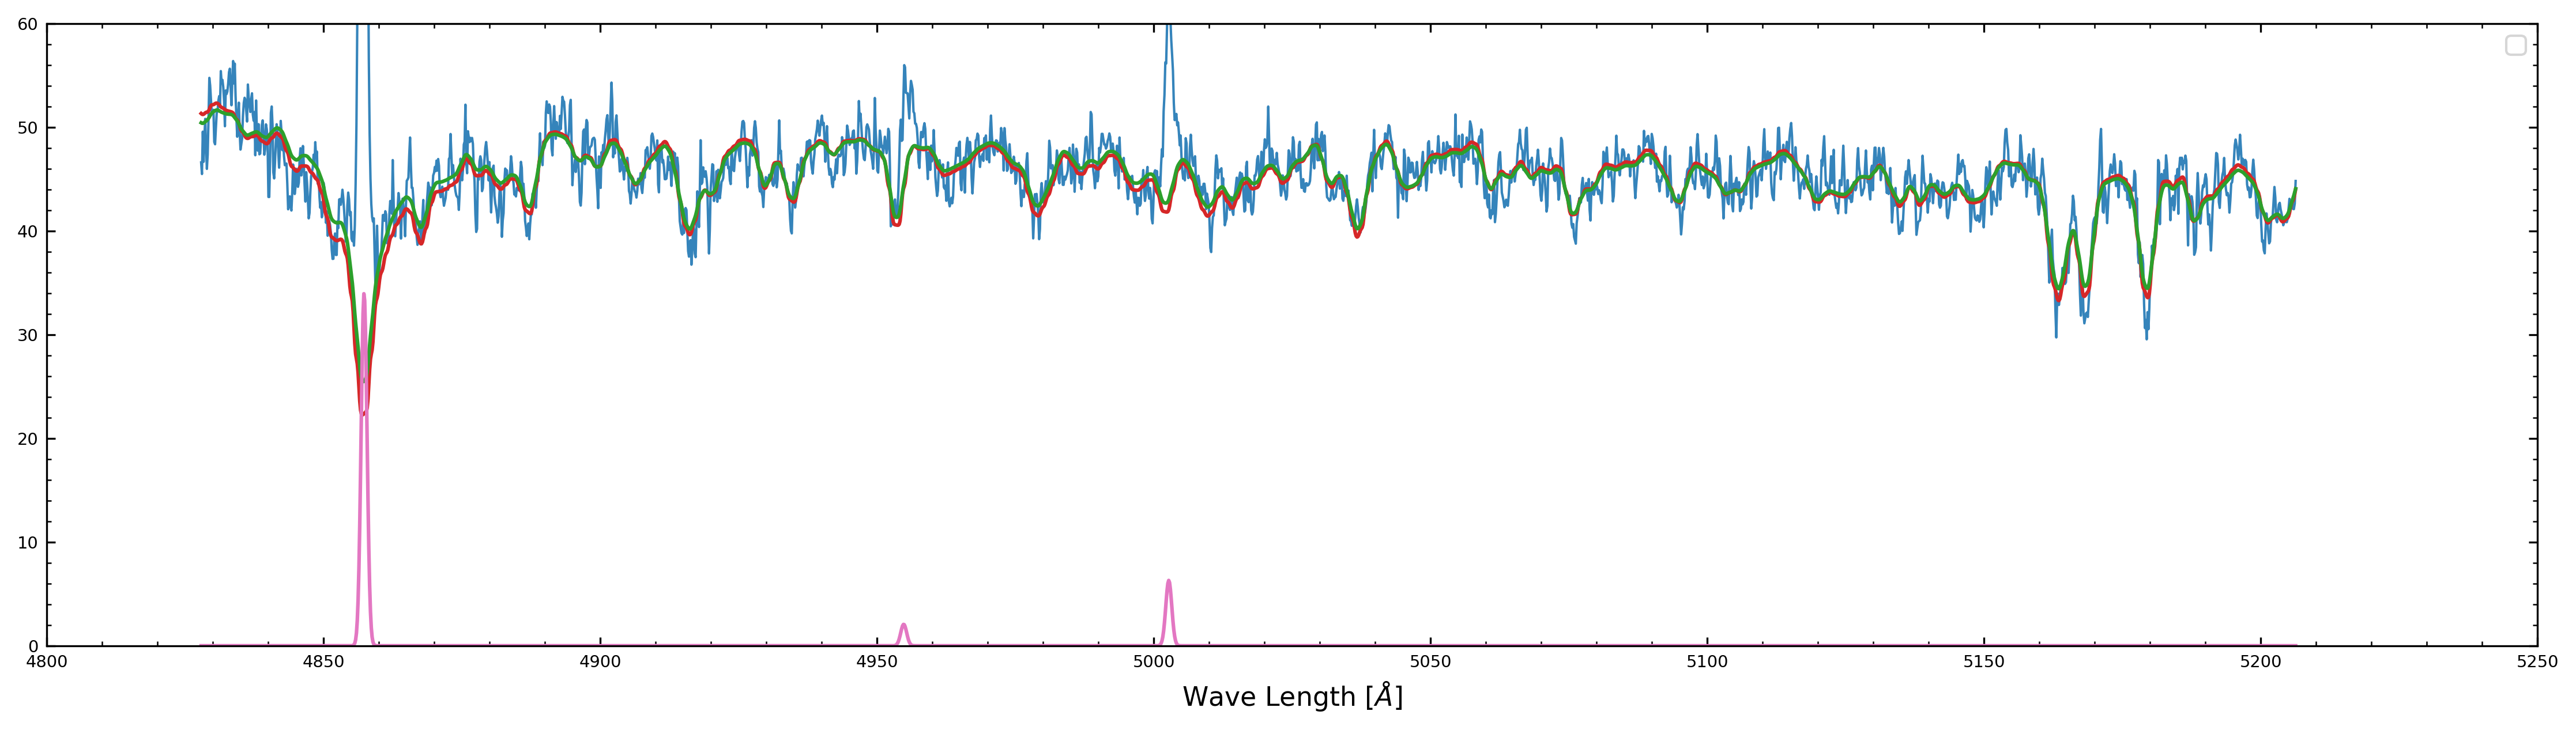

In [713]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal_new,VNB_spectrum_new[:,2], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal_new,Bestfitfield_VNB[:,2], c='tab:red')
ax1.plot(lam_gal_new, PP_box[2].bestfit - PP_box[2].gas_bestfit_templates[:,0] - PP_box[2].gas_bestfit_templates[:,1], c='tab:green')
ax1.plot(lam_gal_new,PP_box[0].gas_bestfit, c='tab:pink')


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(0,60)
ax1.set_xlim(4800,5250)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [714]:
for i in range(len(VNB[6])):
        
        K_index = i
        # spectrum_fit_NEL = PP_box[K_index].bestfit
        # for k in [0,1]:
        #     spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]
        spectrum_fit_NEL = PP_box[K_index].bestfit- PP_box[K_index].gas_bestfit_templates[:,0]- PP_box[K_index].gas_bestfit_templates[:,1]

        wave = sps.lam_temp
        flux = optimal_templates_otp[:,i]

        em_wave = lam_gal_new
        # em_flux_list = np.ndarray(shape=lam_gal.shape)
        # for em_k in [0,1]:
        #         em_flux_list += PP_box[K_index].gas_bestfit  # 使用ppxf的发射线拟合结果
        em_flux_list = PP_box[K_index].gas_bestfit

        calculator = LineIndexCalculator(lam_gal_new, VNB_spectrum_new[:,i],
                                                wave, flux,
                                                em_wave=em_wave, em_flux_list=em_flux_list,
                                                velocity_correction=PP_box[K_index].sol[0][0])
        
        # calculator.plot_line_fit('Hbeta')

        H_Beta_map[i] = calculator.calculate_index('Hbeta')
        Fe_5015_map[i] = calculator.calculate_index('Fe5015')
        Mg_b_map[i] = calculator.calculate_index('Mgb')

In [715]:
# LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
# RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])

In [716]:
# x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
# y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
# y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))

In [717]:
# for i in range(len(VNB[6])):
        
#         K_index = i
#         spectrum_fit_NEL = PP_box[K_index].bestfit
#         for k in [0,1]:
#             spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

#         LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
#         RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])
#         LCB = Index_Wave.loc[0,'CBP_range'][0]
#         RCB = Index_Wave.loc[0,'CBP_range'][1]
#         LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'BPC_range'][1])) ])
#         RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'RPC_range'][1])) ])

#         # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

#         x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
#         y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
#         y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

#         NS = y_SL[:,i] - y_spectrum[:,i]
#         for k in range(len(y_SL[:,i])):
#             NS[k] = NS[k]/y_SL[k,i]

#         H_Beta_map[i] = np.trapz(NS, x_wave[:,i])

In [718]:
# #Fe 5015

# LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
# RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])

In [719]:
# #Fe 5015

# x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
# y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
# y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))

In [720]:
# #Fe 5015

# for i in range(len(VNB[6])):
        
#         K_index = i
#         spectrum_fit_NEL = PP_box[K_index].bestfit
#         for k in [0,1]:
#             spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

#         LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
#         RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])
#         LCB = Index_Wave.loc[1,'CBP_range'][0]
#         RCB = Index_Wave.loc[1,'CBP_range'][1]
#         LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'BPC_range'][1])) ])
#         RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'RPC_range'][1])) ])

#         # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

#         x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
#         y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
#         y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

#         NS = y_SL[:,i] - y_spectrum[:,i]
#         for k in range(len(y_SL[:,i])):
#             NS[k] = NS[k]/y_SL[k,i]

#         Fe_5015_map[i] = np.trapz(NS, x_wave[:,i])

In [721]:
# #Mg b

# LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
# RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])

In [722]:
# #Mg b

# x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
# y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))
# y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),len(VNB[6])))

In [723]:
# #Mg b

# for i in range(len(VNB[6])):
        
#         K_index = i
#         spectrum_fit_NEL = PP_box[K_index].bestfit
#         for k in [0,1]:
#             spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]


#         LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
#         RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])
#         LCB = Index_Wave.loc[2,'CBP_range'][0]
#         RCB = Index_Wave.loc[2,'CBP_range'][1]
#         LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'BPC_range'][1])) ])
#         RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'RPC_range'][1])) ])

#         # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

#         x_wave[:,i] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
#         y_spectrum[:,i] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
#         y_SL[:,i] = x_wave[:,i] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

#         NS = y_SL[:,i] - y_spectrum[:,i]
#         for k in range(len(y_SL[:,i])):
#             NS[k] = NS[k]/y_SL[k,i]

#         Mg_b_map[i] = np.trapz(NS, x_wave[:,i])

## OTP

In [724]:
names = ['Hbeta', '[OIII]5007_d']
c_kms = 299792.458  # speed of light in km/s

In [725]:
VNB_Sol = pd.DataFrame({'H_beta_EL_value':[],'H_beta_EL_ANR':[],
                        'O_3_5007_EL_value':[],'O_3_5007_EL_ANR':[],
                        'Component_Sol':[],
                        'H_beta_SI':[],'Mg_b_SI':[],'Fe_5015_SI':[],
                        'R':[],'SNR':[],'Signal':[],'Noise':[],
                        'K_index':[]})

In [726]:
for Index_num in range(len(VNB[2])):
    K_index = np.where(VNB[0] == Index_num)[0]
    dx = []
    dy = []
    dr = []

    for k_index in K_index:
        i = int(k_index/max(Galaxy_info.col))
        j = k_index%max(Galaxy_info.col)

        Ori_ra  = Galaxy_info.CRVAL1 + ((i)*Galaxy_info.CD1_2) + ((j)*Galaxy_info.CD1_1) + (Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2
        Ori_dec = Galaxy_info.CRVAL2 + ((i)*Galaxy_info.CD2_2) + ((j)*Galaxy_info.CD2_1) + (Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2
        O_x = (Galaxy_info.CRVAL1 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD1_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD1_1))/2)
        O_y = (Galaxy_info.CRVAL2 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD2_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD2_1))/2)
        dx += [Ori_ra - O_x]
        dy += [Ori_dec - O_y]
        dr += [np.sqrt((Ori_ra - O_x)**2 + (Ori_dec - O_y)**2)]
    R = np.mean(dr)

    rms = robust_sigma(VNB_spectrum_new[:,Index_num] - PP_box[Index_num].bestfit, zero=1)
    for p, name in enumerate(names):
        kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
        dlam = line_wave[kk]*Galaxy_info.velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
        flux = (PP_box[Index_num].gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
        an = np.max(PP_box[Index_num].gas_bestfit_templates[:, kk])/rms
        if(kk[0]):
            H_Beta_EL = flux
            H_Beta_EL_AN = an
        if(kk[1]):
            O_5007_EL = flux
            O_5007_EL_AN = an

    S_val = np.mean(VNB_spectrum_new[:,Index_num][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[Index_num].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])
    N_val = np.std(VNB_spectrum_new[:,Index_num][ np.where((lam_gal>5075) & (lam_gal<5125)) ]/PP_box[Index_num].bestfit[ np.where((lam_gal>5075) & (lam_gal<5125)) ])


    VNB_Sol_lim = pd.DataFrame({'H_beta_EL_value':[H_Beta_EL],'H_beta_EL_ANR':[H_Beta_EL_AN],
                        'O_3_5007_EL_value':[O_5007_EL],'O_3_5007_EL_ANR':[O_5007_EL_AN],
                        'Component_Sol':[PP_box[Index_num].sol],
                        'H_beta_SI':[H_Beta_map[Index_num]],'Mg_b_SI':[Mg_b_map[Index_num]],'Fe_5015_SI':[Fe_5015_map[Index_num]],
                        'R':[R],'SNR':[S_val/N_val],'Signal':[S_val],'Noise':[N_val],'K_index':[K_index]})
    VNB_Sol = TB_reindex(pd.concat([VNB_Sol, VNB_Sol_lim]))

In [727]:
VNB_Sol.to_csv('./../FitData/Fit_DS_25[25Feb25][VCC1588]/'+galaxy_name+'_VNB_SFR.csv')

In [728]:
# VNB_Sol